In [28]:
# Install required packages if missing
%pip install -q tensorflow matplotlib numpy

# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
def load_cifar10_data(data_dir):
    """Load CIFAR-10 dataset from extracted local directory."""
    def load_batch(file):
        with open(file, 'rb') as f:
            data_dict = pickle.load(f, encoding='bytes')
            X = data_dict[b'data']
            Y = data_dict[b'labels']
            X = X.reshape(len(X), 3, 32, 32).transpose(0, 2, 3, 1)
            return X, Y

    # Load training batches
    x_train, y_train = [], []
    for i in range(1, 6):
        file = os.path.join(data_dir, f'data_batch_{i}')
        X, Y = load_batch(file)
        x_train.append(X)
        y_train += Y

    x_train = np.concatenate(x_train)
    y_train = np.array(y_train)

    # Load test batch
    x_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))
    y_test = np.array(y_test)

    return (x_train, y_train), (x_test, y_test)


# Load local dataset
data_dir = './cifar10/cifar-10-batches-py'
(x_train, y_train), (x_test, y_test) = load_cifar10_data(data_dir)

print("Training set:", x_train.shape)
print("Test set:", x_test.shape)


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)


In [30]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding (10 classes)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("One-hot label shape:", y_train.shape)


One-hot label shape: (50000, 10)


In [31]:
# Load pretrained VGG16 model (without the top classifier)
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

# Freeze bottom layers, unfreeze top 4 conv layers for fine-tuning
for layer in base_model.layers[:-6]:
    layer.trainable = False
for layer in base_model.layers[-6:]:
    layer.trainable = True

print("Trainable layers:", sum([l.trainable for l in base_model.layers]))

# Build full model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 output classes for CIFAR-10
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Trainable layers: 6


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 9,573,130 (36.52 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

In [32]:
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 232ms/step - accuracy: 0.5824 - loss: 1.2409 - val_accuracy: 0.7151 - val_loss: 0.8295
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 298ms/step - accuracy: 0.7238 - loss: 0.8349 - val_accuracy: 0.7360 - val_loss: 0.7532
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 353ms/step - accuracy: 0.7718 - loss: 0.6797 - val_accuracy: 0.7635 - val_loss: 0.7037
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 247ms/step - accuracy: 0.8112 - loss: 0.5654 - val_accuracy: 0.7625 - val_loss: 0.7206
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 250ms/step - accuracy: 0.8462 - loss: 0.4569 - val_accuracy: 0.7759 - val_loss: 0.6922
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 262ms/step - accuracy: 0.8748 - loss: 0.3654 - val_accuracy: 0.7747 - val_loss: 0.7747
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 173s 276ms/step - accuracy: 0.9049 - loss: 0.2790 - val_accuracy: 0.7668 - val_loss: 0.8686
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 254ms/step - accuracy: 0.9259 -

In [33]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"\n✅ Test accuracy: {test_acc*100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

    


313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 96ms/step - accuracy: 0.7680 - loss: 1.2457

✅ Test accuracy: 76.80%
Test loss: 1.2457


In [35]:
model.save("cifar10_vgg16_finetuned.keras")


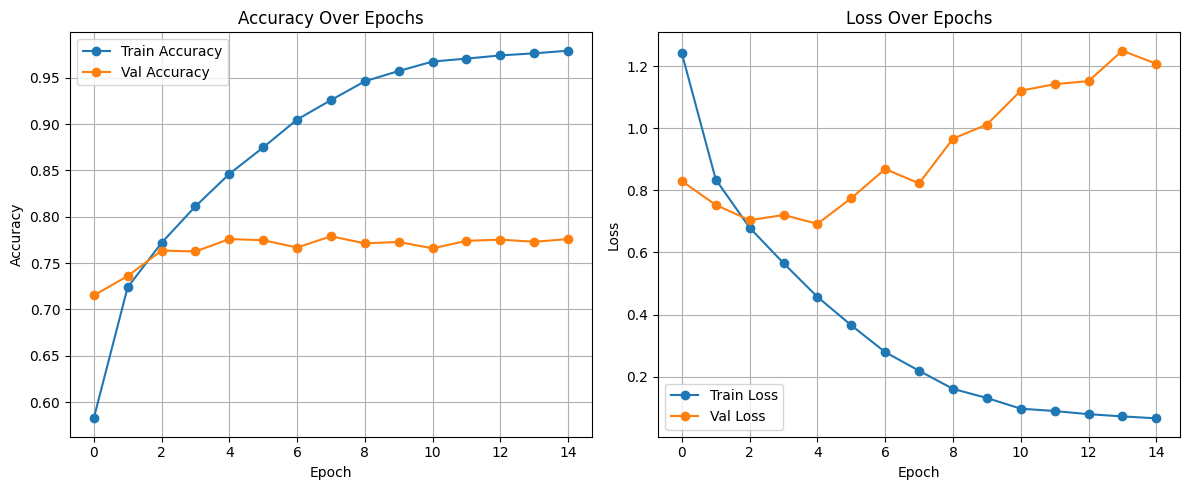


Model saved as vgg16_cifar10_best.keras ✅


In [36]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# =========================================================
# 8️⃣ Save model
# =========================================================
model.save('vgg16_cifar10_best.keras')
print("\nModel saved as vgg16_cifar10_best.keras ✅")